In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os

In [23]:
data = pd.read_csv("/Users/insiyar/Documents/Development/bird-song-classifier/CNN-Workflow/spectrogram_species_data.csv")

In [24]:
data.describe

<bound method NDFrame.describe of           id     species               name  png_filename
0     557838    bewickii      Bewick's Wren  557838-0.png
1     557838    bewickii      Bewick's Wren  557838-1.png
2     557838    bewickii      Bewick's Wren  557838-4.png
3     557838    bewickii      Bewick's Wren  557838-5.png
4     557838    bewickii      Bewick's Wren  557838-6.png
...      ...         ...                ...           ...
5417   11713  cardinalis  Northern Cardinal   11713-8.png
5418   11713  cardinalis  Northern Cardinal  11713-10.png
5419   11713  cardinalis  Northern Cardinal  11713-14.png
5420   11713  cardinalis  Northern Cardinal  11713-15.png
5421   11713  cardinalis  Northern Cardinal  11713-16.png

[5422 rows x 4 columns]>

In [25]:
labels = data['name'].unique() 
print(labels)

["Bewick's Wren" 'Northern Mockingbird' 'American Robin' 'Song Sparrow'
 'Northern Cardinal']


In [26]:
# Split the dataset into training, validation, and testing sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [27]:
from tqdm import tqdm

def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255. # Normalize pixel values to [0, 1]
    return img_array

def process_images_in_batches(data, batch_size=500):
    images = []
    labels = []
    for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Processing images"):
        img_path = os.path.join('/Users/insiyar/Documents/Development/bird-song-classifier/output_spectrogram_folder', row['png_filename'])
        img_array = load_and_preprocess_image(img_path)
        images.append(img_array)
        labels.append(row['species'])
        
        if len(images) % batch_size == 0:
            images = np.concatenate(images, axis=0) 
            labels = np.array(labels)
            yield images, labels
            images = []
            labels = []
    
    if images:
        images = np.concatenate(images, axis=0) 
        labels = np.array(labels)
        yield images, labels

# Process the training and testing sets in batches
train_images, train_labels = [], []
test_images, test_labels = [], []
validation_images = []
validation_labels = []

for batch_images, batch_labels in process_images_in_batches(train_data):
    train_images.append(batch_images)
    train_labels.append(batch_labels)

for batch_images, batch_labels in process_images_in_batches(test_data):
    test_images.append(batch_images)
    test_labels.append(batch_labels)

for batch_images, batch_labels in process_images_in_batches(validation_data):
    validation_images.append(batch_images)
    validation_labels.append(batch_labels)

train_images = np.concatenate(train_images, axis=0) # Ensure train_images is a 4D array
train_labels = np.concatenate(train_labels, axis=0) # Ensure train_labels is a 1D array
test_images = np.concatenate(test_images, axis=0) # Ensure test_images is a 4D array
test_labels = np.concatenate(test_labels, axis=0) # Ensure test_labels is a 1D array
validation_images = np.concatenate(validation_images, axis=0) # Ensure validation_images is a 4D array
validation_labels = np.concatenate(validation_labels, axis=0) # Ensure validation_labels is a 1D array

Processing images: 100%|██████████| 813/813 [00:11<00:00, 72.89it/s]


In [32]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(validation_labels)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


/Users/insiyar/anaconda3/envs/audio/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [30]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform train_labels
train_labels = label_encoder.fit_transform(train_labels)

# Transform test_labels
test_labels = label_encoder.transform(test_labels)

# Transform validation_labels
validation_labels = label_encoder.transform(validation_labels)

# Print the unique encoded labels
print("Encoded class labels:", np.unique(train_labels))

# Print the mapping of original class labels to encoded labels
print("Class label mapping:", dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))))

Encoded class labels: [0 1 2 3 4]
Class label mapping: {'bewickii': 0, 'cardinalis': 1, 'melodia': 2, 'migratorius': 3, 'polyglottos': 4}


In [35]:
history = model.fit(train_generator, epochs=10, validation_data=(validation_images, validation_labels))


Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.3038 - loss: 1.5359 - val_accuracy: 0.3272 - val_loss: 1.4590
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.3561 - loss: 1.4625 - val_accuracy: 0.4453 - val_loss: 1.3229
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 4454s 38s/step - accuracy: 0.4149 - loss: 1.3690 - val_accuracy: 0.4797 - val_loss: 1.2666
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.4340 - loss: 1.3273 - val_accuracy: 0.4428 - val_loss: 1.2990
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 1837s 16s/step - accuracy: 0.4317 - loss: 1.2966 - val_accuracy: 0.5892 - val_loss: 1.0576
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4997 - loss: 1.2124 - val_accuracy: 0.5695 - val_loss: 1.0392
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy: 0.5338 - loss: 1.1574 - val_accuracy: 0.5683 - val_loss: 1.0090
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 610s 5s/step - accuracy: 0.5555 - loss: 1.1128 - val_

26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 323ms/step - accuracy: 0.6853 - loss: 0.8031
Test accuracy: 0.6793611645698547


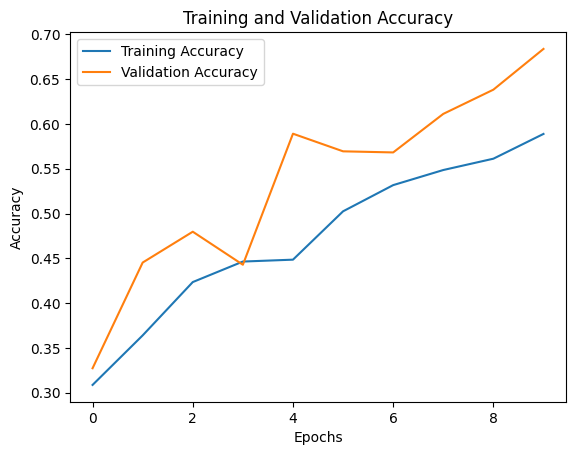

In [36]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_acc}')

# Plot the training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [37]:
history = model.fit(train_images, train_labels, epochs=10, validation_data=(validation_images, validation_labels))

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.6900 - loss: 0.8087 - val_accuracy: 0.7761 - val_loss: 0.5707
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8068 - loss: 0.5322 - val_accuracy: 0.8057 - val_loss: 0.5044
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8558 - loss: 0.3879 - val_accuracy: 0.8475 - val_loss: 0.4477
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.8923 - loss: 0.2889 - val_accuracy: 0.8549 - val_loss: 0.3783
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.9223 - loss: 0.2200 - val_accuracy: 0.8659 - val_loss: 0.3605
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 299s 3s/step - accuracy: 0.9495 - loss: 0.1550 - val_accuracy: 0.8770 - val_loss: 0.3896
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 806s 7s/step - accuracy: 0.9521 - loss: 0.1126 - val_accuracy: 0.8672 - val_loss: 0.4102
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 5169s 44s/step - accuracy: 0.9677 - loss: 0.0915 - val_ac